In [1]:
import json
import csv
from google.colab import files
uploaded = files.upload()

Saving dev_matched_sampled-1.jsonl to dev_matched_sampled-1.jsonl
Saving dev_mismatched_sampled-1.jsonl to dev_mismatched_sampled-1.jsonl


In [22]:
!pip install torch
!pip install transformers

In [23]:
import torch
import json
import pandas as pd
from tqdm import trange
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader


def load_dataset(path):
    with open(path, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]

    dataset = []
    for item in data:
        if 'gold_label' in item and item['gold_label'] != '-':
            premise = item['sentence1']
            hypothesis = item['sentence2']
            label = item['gold_label']
            dataset.append({'premise': premise, 'hypothesis': hypothesis, 'label': label})

    return dataset


class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        prompt_sentence ="Determine if the hypothesis is true (entailment), false (contradiction), or neutral based on the premise. Premise: " + item['premise'] + " Hypothesis: " + item['hypothesis']
        encoding = self.tokenizer(prompt_sentence,
                                  item['premise'],
                                  item['hypothesis'],
                                  padding='max_length',
                                  max_length=self.max_length,
                                  truncation=True,
                                  return_tensors='pt')
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        label_id = self.label_map[item['label']]
        return input_ids, attention_mask, label_id

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, label_id = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label_id = label_id.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=label_id)
            loss = outputs.loss
            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, dim=1)
            total_correct += torch.sum(predicted == label_id).item()
    average_loss = total_loss / len(dataloader)
    accuracy =  total_correct / len(dataloader.dataset)

    return average_loss, accuracy

#Bert

In [24]:
# Matched Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
matched_data = load_dataset('dev_matched_sampled-1.jsonl')
matched_dataset = NLIDataset(matched_data, tokenizer, max_length=128)
matched_dataloader = DataLoader(matched_dataset, batch_size=16, shuffle=True)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
criterion = torch.nn.CrossEntropyLoss()

validation_loss, validation_accuracy = evaluate(bert_model, matched_dataloader, criterion, device)
print('Validation Loss:', validation_loss, 'Validation Accuracy:', validation_accuracy)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens 

Validation Loss: 1.1567224701503656 Validation Accuracy: 0.32439024390243903


In [25]:
# Mismatched Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mismatched_data = load_dataset('dev_mismatched_sampled-1.jsonl')
mismatched_dataset = NLIDataset(mismatched_data, tokenizer, max_length=128)
mismatched_dataloader = DataLoader(mismatched_dataset, batch_size=16, shuffle=True)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
criterion = torch.nn.CrossEntropyLoss()

validation_loss_2, validation_accuracy_2 = evaluate(bert_model, mismatched_dataloader, criterion, device)
print('Validation Loss:', validation_loss_2, 'Validation Accuracy:', validation_accuracy_2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens 

Validation Loss: 1.1023869963435384 Validation Accuracy: 0.36079545454545453


#Bart

In [26]:
from transformers import BartTokenizer, BartForSequenceClassification

In [27]:
# Matched Data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
matched_data = load_dataset('dev_matched_sampled-1.jsonl')
matched_dataset = NLIDataset(matched_data, tokenizer, max_length=128)
matched_dataloader = DataLoader(matched_dataset, batch_size=16, shuffle=True)

bart_model = BartForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bart_model.to(device)
criterion = torch.nn.CrossEntropyLoss()

validation_loss_3, validation_accuracy_3 = evaluate(bart_model, matched_dataloader, criterion, device)
print('Validation Loss:', validation_loss_3, 'Validation Accuracy:', validation_accuracy_3)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So

Validation Loss: 1.110026096368765 Validation Accuracy: 0.32723577235772355


In [28]:
# Mismatched Data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
mismatched_data = load_dataset('dev_mismatched_sampled-1.jsonl')
mismatched_dataset = NLIDataset(mismatched_data, tokenizer, max_length=128)
mismatched_dataloader = DataLoader(mismatched_dataset, batch_size=16, shuffle=True)

bart_model = BartForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bart_model.to(device)
criterion = torch.nn.CrossEntropyLoss()

validation_loss_4, validation_accuracy_4 = evaluate(bart_model, mismatched_dataloader, criterion, device)
print('Validation Loss:', validation_loss_4, 'Validation Accuracy:', validation_accuracy_4)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So

Validation Loss: 1.0979262559444873 Validation Accuracy: 0.3628246753246753


In [29]:
example_sentence_mismatched = mismatched_data[0]
example_sentence_mismatched


{'premise': 'Further, there is no universally accepted way to transliterate Arabic words and names into English.',
 'hypothesis': 'Arabic words and names are easily translated.',
 'label': 'contradiction'}

In [30]:
example_sentence_matched = matched_data[0]
example_sentence_matched


{'premise': 'oh that sounds interesting too',
 'hypothesis': 'That is not very attention grabbing. ',
 'label': 'contradiction'}

#*Mismatched*

In [31]:

# Function to predict using a model
def predict(model, tokenizer, premise, hypothesis, max_length):
    # Tokenize the input
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Model inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return prediction

# Load models and tokenizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bart_model = BartForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=3).to(device)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

# Example sentence pair
premise =  example_sentence_mismatched['premise']
hypothesis = example_sentence_mismatched['hypothesis']

# Predictions
bert_prediction = predict(bert_model, bert_tokenizer, premise, hypothesis, max_length=128)
bart_prediction = predict(bart_model, bart_tokenizer, premise, hypothesis, max_length=128)

# Convert predictions to labels
label_map = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}
bert_label = label_map[bert_prediction]
bart_label = label_map[bart_prediction]

print(f"BERT Prediction: {bert_label}")
print(f"BART Prediction: {bart_label}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Prediction: entailment
BART Prediction: neutral


#Matched

In [32]:

# Function to predict using a model
def predict(model, tokenizer, premise, hypothesis, max_length):
    # Tokenize the input
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Model inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return prediction

# Load models and tokenizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bart_model = BartForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=3).to(device)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

# Example sentence pair
premise =  example_sentence_matched['premise']
hypothesis = example_sentence_matched['hypothesis']

# Predictions
bert_prediction = predict(bert_model, bert_tokenizer, premise, hypothesis, max_length=128)
bart_prediction = predict(bart_model, bart_tokenizer, premise, hypothesis, max_length=128)

# Convert predictions to labels
label_map = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}
bert_label = label_map[bert_prediction]
bart_label = label_map[bart_prediction]

print(f"BERT Prediction: {bert_label}")
print(f"BART Prediction: {bart_label}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Prediction: neutral
BART Prediction: neutral


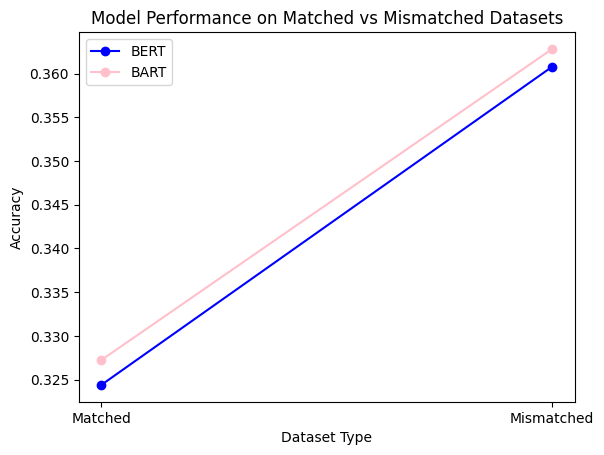

In [33]:
import matplotlib.pyplot as plt

# Example accuracy data for BERT and BART on matched and mismatched datasets
# Replace these with your actual accuracies
bert_accuracies = {'Matched': validation_accuracy, 'Mismatched': validation_accuracy_2}  # BERT accuracies
bart_accuracies = {'Matched': validation_accuracy_3, 'Mismatched': validation_accuracy_4}  # BART accuracies

# Data for plotting
models = ['BERT', 'BART']
data_types = ['Matched', 'Mismatched']
accuracies = [
    [bert_accuracies['Matched'], bert_accuracies['Mismatched']],
    [bart_accuracies['Matched'], bart_accuracies['Mismatched']]
]

colors = ['blue', 'pink']


# Create the plot
fig, ax = plt.subplots()
for i, model in enumerate(models):
    ax.plot(data_types, accuracies[i], label=model, marker='o',color=colors[i])

# Add labels and legend
ax.set_xlabel('Dataset Type')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance on Matched vs Mismatched Datasets')
ax.legend()

# Show the plot
plt.show()